In [ ]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
import scipy.integrate as integrate
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He



    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/{}_cloudy.txt'.format(atom), sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/{}_cloudy.txt'.format(atom), sep='\t',index = False,header=False)
    return print("make data file!")





def SB(z, radius_kpc, emissivity, dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()
    Project_R = np.linspace(0, 100, 70) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)

    from scipy.interpolate import interp1d
    emis_interp = interp1d(radius_kpc, emissivity, bounds_error=False, fill_value=0)
    
    for ii, R in enumerate(Project_R):
        # 적분 함수 정의
        def integrand(r):
            if r < R:
                return 0
            else:
                emis = emis_interp(r)
                return emis * r / np.sqrt(r**2 - R**2)
            
        surface_brightness[ii], _ = quad(integrand, R, r_max)
        surface_brightness[ii] *= 2 / (1+z)**4
    
    def lumin_integrand(R):
        return 2 * np.pi * R * np.interp(R, Project_R, surface_brightness)
    
    Lumin, _ = quad(lumin_integrand, 0, r_max)
    
    return Project_R / kpc, surface_brightness, Lumin

def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

path_LT = r'/home/jin/T_Cloudy/data_CLOUDY_setting/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT For CIV

RT_path_HeII =r'/home/jin/T_Cloudy/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_CIV = r'/home/jin/T_Cloudy/data_CIV_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'


# make_data_file(path_LT,'CIV')
# make_data_file(path_LT,'HeII')


In [ ]:
# #Window_path
# path_or = r'/home/jin/Data_CIV_code_python/Origin/CIV_Lumin_42' # Ryd =1 or 4 # no OTS , LT 
# path_n = r'/home/jin/Data_CIV_code_python/OTS_y_LT_n/CIV_Lumin_42' # OTS , no LT
# path_y = r'/home/jin/Data_CIV_code_python/OTS_y_LT_y/CIV_Lumin_42' # OTS , yes LT
# path_LT = r'/home/jin/Data_CIV_code_python/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

# #Window_path_RT
# RT_path_or =r'/home/jin/Data_CIV_code_python/Origin/data_RT_ryd_4/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_n =r'/home/jin/Data_CIV_code_python/OTS_y_LT_n/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_y =r'/home/jin/Data_CIV_code_python/OTS_y_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_LT =r'/home/jin/Data_CIV_code_python/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'

In [ ]:
# #Ubuntu_path
# path_or = r'/home/jin/T_Cloudy/Origin/CIV_Lumin_42' # Ryd =1 or 4 # no OTS , LT 
# path_n = r'/home/jin/T_Cloudy/OTS_y_LT_n/CIV_Lumin_42' # OTS , no LT
# path_y = r'/home/jin/T_Cloudy/OTS_y_LT_y/CIV_Lumin_42' # OTS , yes LT
# path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

# #Ubuntu_path_RT

# RT_path_or =r'/home/jin/T_Cloudy/Origin/data_RT_ryd_4/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_n =r'/home/jin/T_Cloudy/OTS_y_LT_n/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_y =r'/home/jin/T_Cloudy/OTS_y_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'

# RT_test = r' /home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'

In [110]:
# make_data_file(path_LT,'CIV')

In [13]:
path_LT = r'/home/jin/T_Cloudy/data_CLOUDY_setting/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT For CIV

RT_path_HeII =r'/home/jin/T_Cloudy/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_CIV = r'/home/jin/T_Cloudy/data_CIV_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'

atom_N = ['HeII','CIV']
def make_parameter(path,RT_path,atom):
    z_red_Shift = 0
    globals()['{}_radius'.format(atom)] , globals()['{}_radius_kpc'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path,atom)
    globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path,atom)
    globals()['{}_rt_radius'.format(atom)] , globals()['{}_rt_radius_kpc'.format(atom)], globals()['{}_rt_sb_t'.format(atom)] = RT_SB(RT_path)
    globals()['{}_p_radius'.format(atom)] , globals()['{}_SB'.format(atom)], globals()['{}_lum_SB'.format(atom)] = SB(z_red_Shift,globals()['{}_radius_kpc'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)]) # , globals()['rt_radius_kpc_{}'.format(atom)]
    return print("make parameters of {}".format(atom))

for atom in atom_N:
    make_parameter(path_LT,globals()['RT_path_{}'.format(atom)],atom)

make parameters of HeII
make parameters of CIV


In [ ]:
# def make_parameter(path,RT_path,atom,cloudy_index):
#     z_red_Shift = 0
#     globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
#     globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
#     globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
#     globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)]) # , globals()['rt_radius_kpc_{}'.format(cloudy_index)]
#     return print("make parameters of {}".format(cloudy_index))

# for ii ,cloudy_index in enumerate (cloudy_model) :
#     make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

make parameters of LT


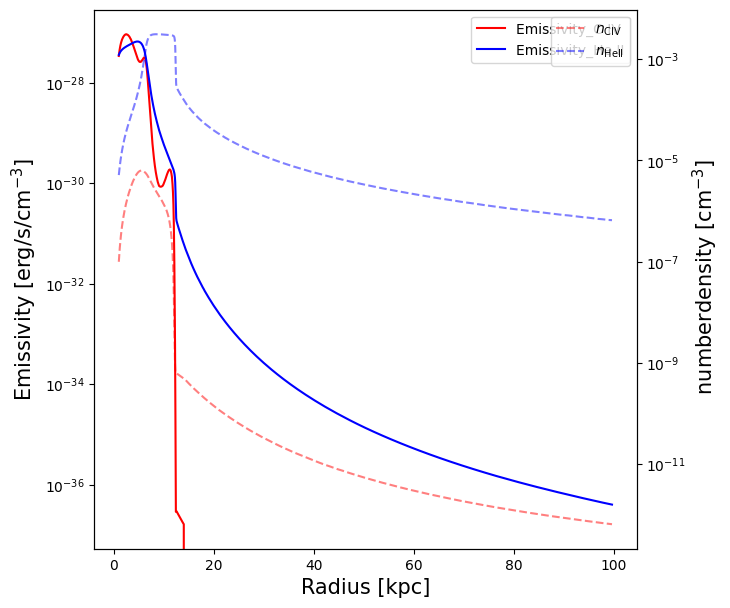

In [23]:

fig = plt.figure(1, figsize= (7,7))
# plt.xlim(-0.5,20)
ax1 = plt.gca()
ax2 = ax1.twinx()  

ax1.plot(CIV_radius, CIV_emis ,'r-',label='Emissivity_C IV')

ax2.plot(CIV_radius, CIV_den, 'r--',alpha = 0.5, label=r'$n_{\rm CIV}$')

ax1.plot(HeII_radius, HeII_emis ,'b-',label='Emissivity_He II')

ax2.plot(HeII_radius, HeII_den, 'b--',alpha = 0.5, label=r'$n_{\rm He II}$')

ax1.set_xlabel('Radius [kpc]',fontsize=15)

ax1.set_ylabel(r'$\rm Emissivity \  [\rm erg/s/cm^{-3}]$',fontsize = 15)
ax2.set_ylabel(r' $\rm number density \ [\rm cm^{-3}]$ ',fontsize = 15)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend()
ax2.legend()




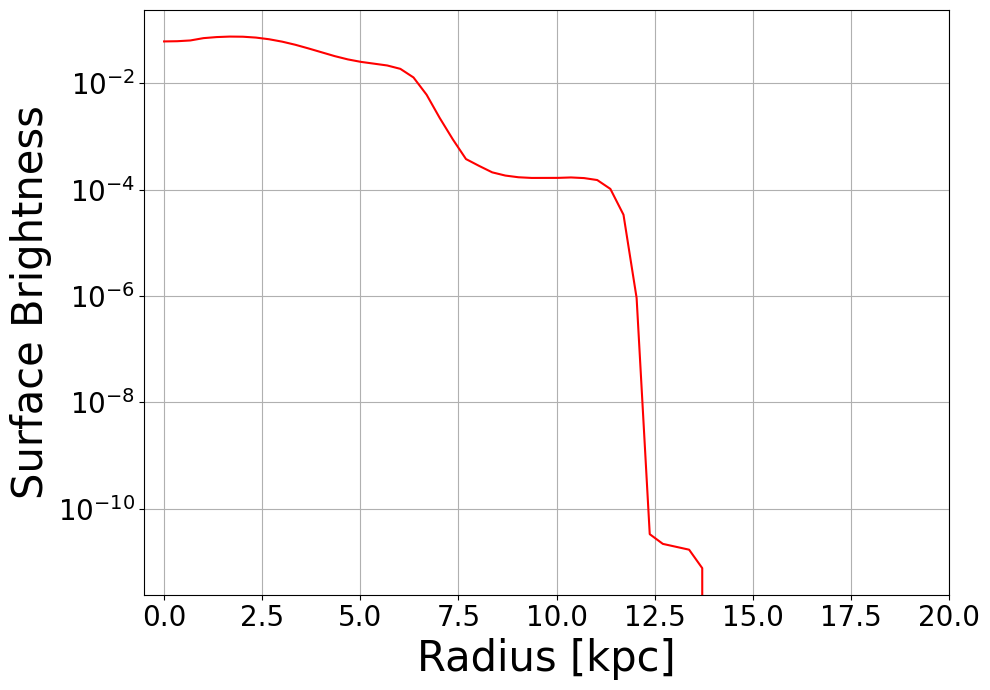

In [ ]:

fig = plt.figure(1, figsize= (7,7))
plt.xlim(-0.5,20)
ax1 = plt.gca()
ax2 = ax1.twinx()  

normal_cloudy = np.sum(globals()['sb_{}'.format(cloudy_index)] )

ax1.plot(globals()['p_radius_{}'.format(cloudy_index)], globals()['sb_{}'.format(cloudy_index)]  / normal_cloudy  ,'r-',label='SB_CLOUDY_{}'.format(cloudy_index))

normal_RT = np.sum(globals()['rt_sb_t_{}'.format(cloudy_index)])

ax1.plot(globals()['rt_radius_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)]/normal_RT  ,'bo',label='SB_RT_{}'.format(cloudy_index))


ax2.plot(globals()['radius_{}'.format(cloudy_index)], globals()['civ_emis_{}'.format(cloudy_index)], 'r--',alpha = 0.5, label='emis_{}'.format(cloudy_index))
ax1.set_xlabel('Radius [kpc]',fontsize=15)
ax1.set_ylabel('Surface Brightness',fontsize = 15)
ax2.set_ylabel(r'$\rm Emissivity \  [\rm erg/s/cm^{-3}]$',fontsize = 15)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
# ax1.plot(R_project_or[1:]/kpc, SB_or[1:]  ,'bo', label='SB_CLOUDY_or')



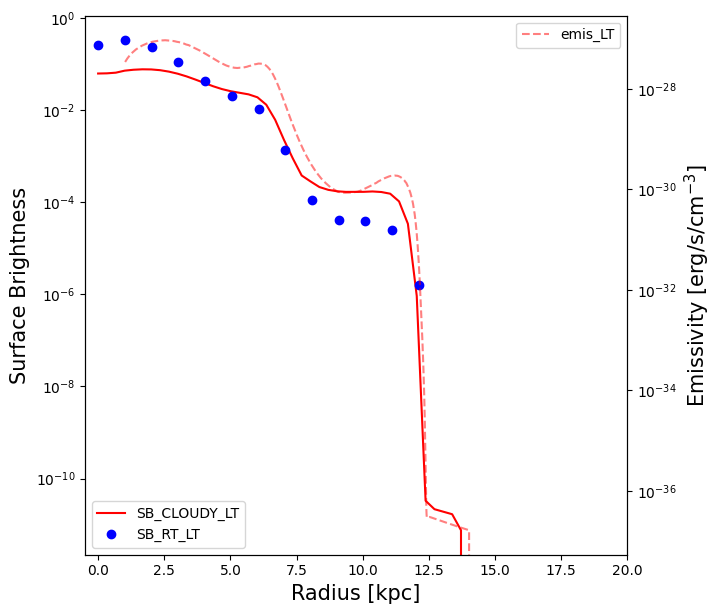

In [116]:
fitting_SB('LT')

In [117]:
# def SB(radius_kpc, emissivity):

#     emis_int = interpolate.interp1d(radius_kpc, emissivity)

#     r_min, r_max = radius_kpc.min(), radius_kpc.max()

#     Project_R = np.linspace(0, r_max, 70)

#     surface_brightness = np.zeros(len(Project_R))

#     for ii, R in enumerate(Project_R):

#         def function(r):

#             if r <= r_min:

#                 emis = emis_int(r)

#                 return emis

#             else:

#                 emis = emis_int(r)

#                 if r**2 - R**2 <= 0:  # 분모가 0이 되는 경우 처리

#                     return 0  # 또는 적절한 값을 반환

#                 yy = emis * r / np.sqrt(r**2 - R**2)

#                 return yy 



#         if R <= r_min:

#             surface_brightness[ii], _ = quad(function, r_min, r_max)    

#         else:

#             surface_brightness[ii], _ = quad(function, R, r_max)   



#     tt = interpolate.interp1d(Project_R, 2*surface_brightness)



#     def test(r):

#         SB_new = tt(r)

#         return SB_new * r

#     LL, _ = quad(test,0,r_max)



#     return Project_R, 2*surface_brightness , LL * 2 *np.pi




# # 내 코드고, 
# test_r, test_sb, test_L = SB(radius_kpc_LT,civ_emis_LT)

In [118]:
print(civ_lum_LT, np.sum(lum_sb_LT))

1.5578665190756982e+40 1.557199390391517e+40


In [119]:
# #ubuntu
# RT_path_LT= r'/home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

# Window
RT_path_LT= r'/home/jin/Data_CIV_code_python/sb_cloudy/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
path_LT = r'/home/jin/Data_CIV_code_python/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

In [120]:

cloudy_model = ['LT'] # or - original (no LT, no Diffuse OTS) , n - no LT (on OTS), y - on LT , OTS, LT- no OTS (on LT)
atom_N = 'CIV'
def make_parameter(path,RT_path,atom,cloudy_index):
    z_red_Shift = 0
    globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
    globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
    globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
    globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)]) # , globals()['rt_radius_kpc_{}'.format(cloudy_index)]
    return print("make parameters of {}".format(cloudy_index))

for ii ,cloudy_index in enumerate (cloudy_model) :
    make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

# rt_sb_t_LT = rt_sb_t_LT / np.sum(rt_sb_t_LT)

make parameters of LT


1.557199390391517e+40 1.5578665190756982e+40


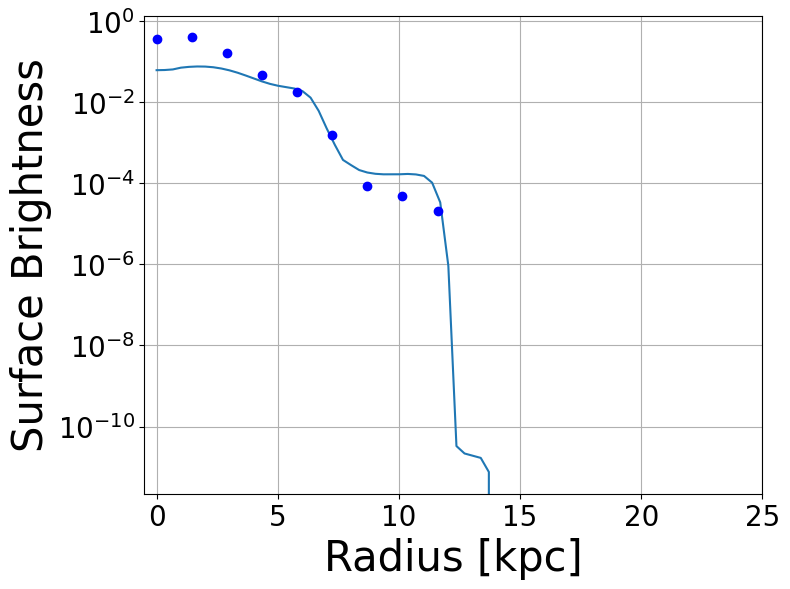

In [123]:
fig = plt.figure(1,figsize=(8,6))

aa ,bb, cc  = SB(0,radius_kpc_LT,civ_emis_LT,dr_LT)
print(np.sum(cc), civ_lum_LT )
normal = np.sum(bb)
plt.plot(aa,bb/normal)

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT,(rt_sb_t_LT / normal) ,'bo')

plt.yscale('log')
plt.xlim(-0.5,25)

plt.xlabel('')
plt.xlabel('Radius [kpc]',fontsize=30)
plt.ylabel('Surface Brightness',fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.tight_layout()


plt.savefig(r'/mnt/c/Users/wlsdl/OneDrive/바탕 화면/RT_CLOUDY.png')